<h1><center>CIFAR-10 Image Classifier - EDA</center></h1>

# 1. Introduction

The goal of this project is to develop an end-to-end machine learning pipeline for image classification using the CIFAR-10 dataset—a widely-used benchmark consisting of 60,000 32x32 color images across 10 distinct categories, such as airplane, cat, dog, and truck.

This pipeline will cover all major stages of a machine learning workflow, including data preprocessing, model selection, training, evaluation, and inference on unseen data.

We aim to accurately classify images into their respective categories by evaluating and comparing the performance of at least three state-of-the-art deep learning architectures. These may include Convolutional Neural Networks (CNNs) like ResNet, VGG, and EfficientNet, as well as modern alternatives like Vision Transformers (ViT).

Through this exploration, we seek to identify the most effective model for this task, based on performance metrics such as accuracy, precision, recall, and inference time.



# 2. EDA

In [ ]:
%load_ext autoreload
%autoreload 2

# ===== Standard Library =====
import os
import random
from collections import defaultdict

# ===== Third-Party Libraries =====
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from torch.nn import CrossEntropyLoss
from torchvision import transforms
from torchvision import transforms as T
from tqdm import tqdm
from dotenv import load_dotenv
from hydra import compose, initialize
# from omegaconf import OmegaConf

# ===== Project-Specific =====
from src.data_loader import load_data, load_raw_cifar10
from src.enums import ModelType
from src.evaluate import evaluate
from src.general_utils import set_global_seed, setup_logging
from src.model import get_model
from src.train import train_model
from src.evaluate import plot_tsne, plot_grad_cam


/opt/anaconda3/envs/a5/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load environment variables
load_dotenv()

True

In [3]:
# Initialize Hydra and set config path
initialize(config_path="conf", version_base="1.3.2")

# Compose the config (you can override defaults if needed)
cfg = compose(config_name="config")  # uses defaults in conf/config.yaml


In [4]:
setup_logging()

In [5]:
# Set Device
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")


Setting the random seeds for reproducibility:

In [6]:
# Set random seeds

set_global_seed()

42

The dataset is available from the pytorch library and we will load it from there.


In [3]:

cifar10_train, cifar10_test= load_raw_cifar10()

{"asctime": "2025-07-03T11:13:50+0800", "process": 13424, "name": "src.data_loader", "levelname": "INFO", "message": "Loading raw CIFAR-10 datasets for EDA..."}


Files already downloaded and verified
Files already downloaded and verified


## 2.1 Initial Analysis

CIFAR-10 Training Set Statistics:
airplane  : 5000 samples
automobile: 5000 samples
bird      : 5000 samples
cat       : 5000 samples
deer      : 5000 samples
dog       : 5000 samples
frog      : 5000 samples
horse     : 5000 samples
ship      : 5000 samples
truck     : 5000 samples


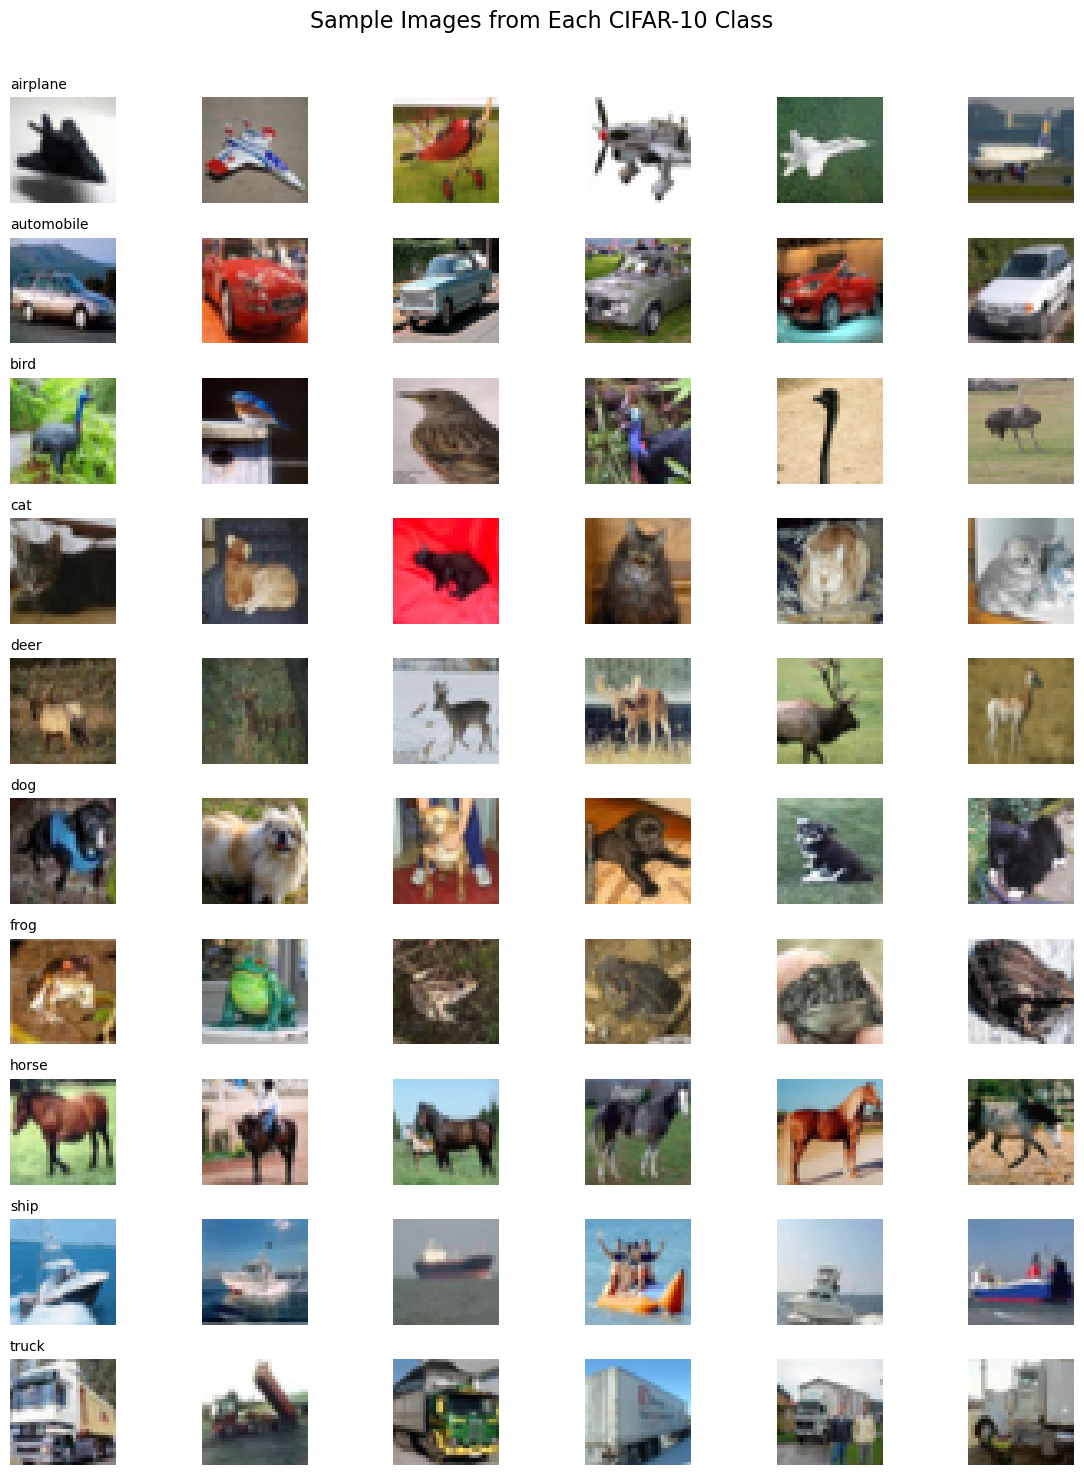

In [4]:

class_names = cifar10_train.classes
class_counts = defaultdict(int)

# --- Count images per class ---
for _, label in cifar10_train:
    class_counts[class_names[label]] += 1

# --- Display class distribution ---
print("CIFAR-10 Training Set Statistics:")
for cls in class_names:
    print(f"{cls:10s}: {class_counts[cls]} samples")

# --- Collect 6 images per class ---
samples_per_class = 6
class_images = {cls: [] for cls in class_names}

for img, label in cifar10_train:
    cls_name = class_names[label]
    if len(class_images[cls_name]) < samples_per_class:
        class_images[cls_name].append(img)
    if all(len(imgs) == samples_per_class for imgs in class_images.values()):
        break

# --- Plot images in a grid ---
fig, axs = plt.subplots(nrows=len(class_names), ncols=samples_per_class, figsize=(12, 15))
fig.suptitle('Sample Images from Each CIFAR-10 Class', fontsize=16)

for row_idx, cls in enumerate(class_names):
    for col_idx in range(samples_per_class):
        axs[row_idx, col_idx].imshow(class_images[cls][col_idx])
        axs[row_idx, col_idx].axis('off')
        if col_idx == 0:
            axs[row_idx, col_idx].set_title(cls, fontsize=10, loc='left')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


The class distributions in the training dataset are evenly balanced with 5000 samples for each class. Based on the displayed samples, the image quality is rather low and we'd should consider using models that are robust to low image quality such as Efficient Net or Vision Transformers.

## 2.1 Dimensions and Colour Channels

Here we take a look at the dimensions and colour channels:

Analyzing images: 100%|██████████| 50000/50000 [00:03<00:00, 15592.95it/s]


Unique image shapes in training set:
  - (32, 32, 3)


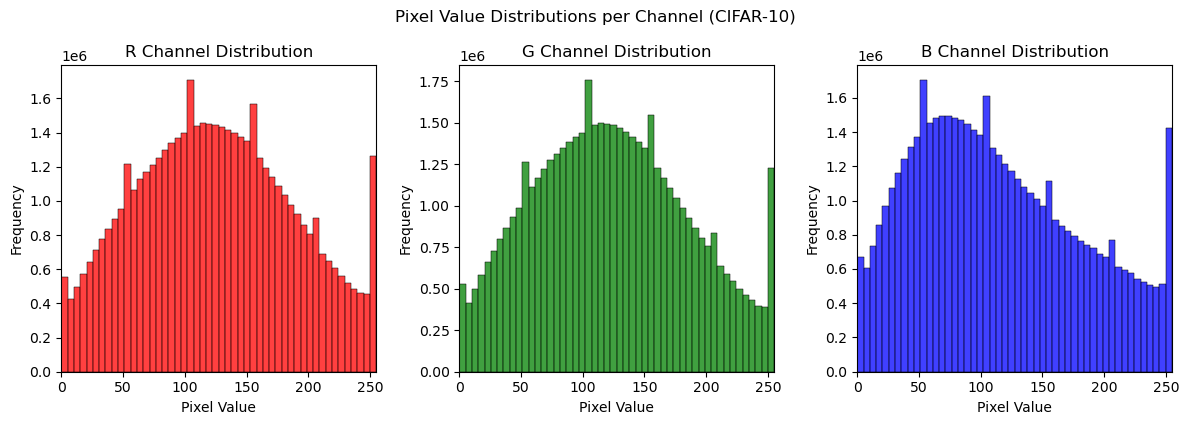

In [5]:
# Convert all images to numpy arrays
image_shapes = []
pixel_values = { 'R': [], 'G': [], 'B': [] }

for img, _ in tqdm(cifar10_train, desc="Analyzing images"):
    np_img = np.array(img)  # shape: (32, 32, 3)
    image_shapes.append(np_img.shape)

    # Split channels
    pixel_values['R'].extend(np_img[:, :, 0].flatten())
    pixel_values['G'].extend(np_img[:, :, 1].flatten())
    pixel_values['B'].extend(np_img[:, :, 2].flatten())

# --- Analyze image dimensions ---
unique_shapes = set(image_shapes)
print("Unique image shapes in training set:")
for shape in unique_shapes:
    print(f"  - {shape}")

# --- Visualization: Pixel Value Distributions ---
plt.figure(figsize=(12, 4))
for i, channel in enumerate(['R', 'G', 'B']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(pixel_values[channel], bins=50, color=channel.lower())
    plt.title(f'{channel} Channel Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.xlim(0, 255)

plt.tight_layout()
plt.suptitle('Pixel Value Distributions per Channel (CIFAR-10)', y=1.05)
plt.show()

### Interpretation of CIFAR-10 Pixel Value Distribution

Each subplot shows the **frequency of pixel intensity values** (0–255) for each color channel (R, G, B) across the entire CIFAR-10 training set.

#### 🔴 Red Channel
- Peak intensity is around **120–130**, meaning most red pixels are in the mid-range.
- Distribution is **slightly left-skewed** (more dark reds than bright reds).
- Some spikes and a notable number of **max-value pixels (255)** — possibly due to saturated red tones.

#### 🟢 Green Channel
- Similar to red but peaks closer to **130–140**.
- Again, slightly left-skewed but more balanced.
- High presence near **0 and 255** — might indicate shadows or highlights in the dataset.

#### 🔵 Blue Channel
- Lower average intensity; peaks around **100–110**.
- Most skewed toward lower values (darker blues).
- Again, some visible spikes at extremes.

---

#### Spikes

- Those sharp spikes at pixel values like **0 or 255** suggest that some images contain **saturated or clipped pixel values**, possibly due to:
  - Low dynamic range in original images
  - JPEG compression artifacts
  - Over-processed or poorly exposed images

---

#### Potential Variations to Watch For

1. **Clipping**: High frequency at 0 and 255 may indicate some images are over/underexposed.
2. **Skewness**: Not all channels are evenly distributed; this could affect color sensitivity in models.
3. **Compression Artifacts**: Jagged peaks may point to JPEG compression artifacts in some original samples.
4. **Illumination Differences**: Uneven channel brightness (e.g., blue being darker) may hint at lighting biases.

---

#### Proposed preprocessing

- **Preprocessing**: Normalize data to offset intensity differences and biases.
- **Data Augmentation**: Adding brightness, contrast jitter, or noise might improve robustness to these variations.

## 2.3 Intra-class variation

Now we take a look at intra-class variation

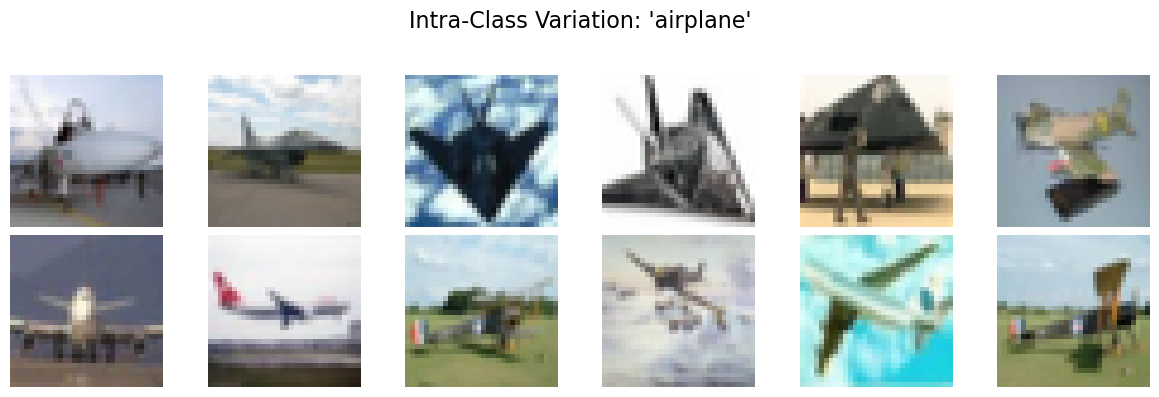

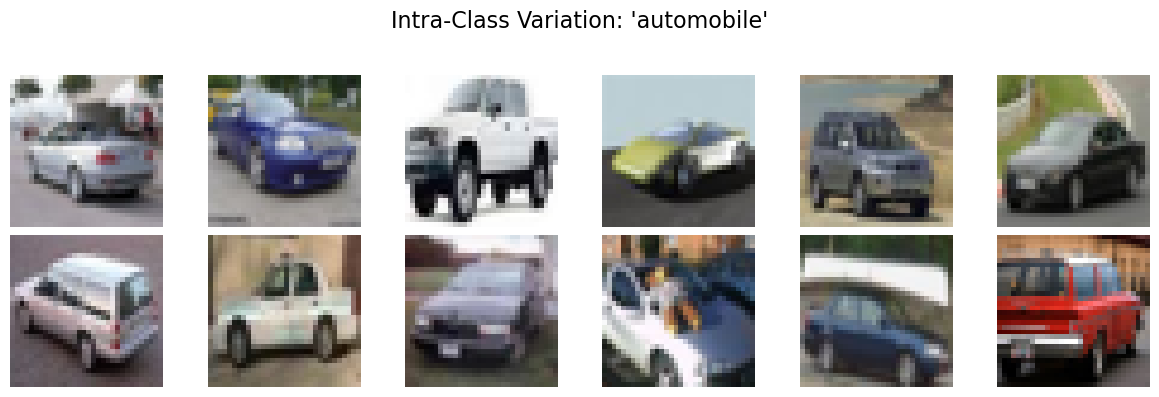

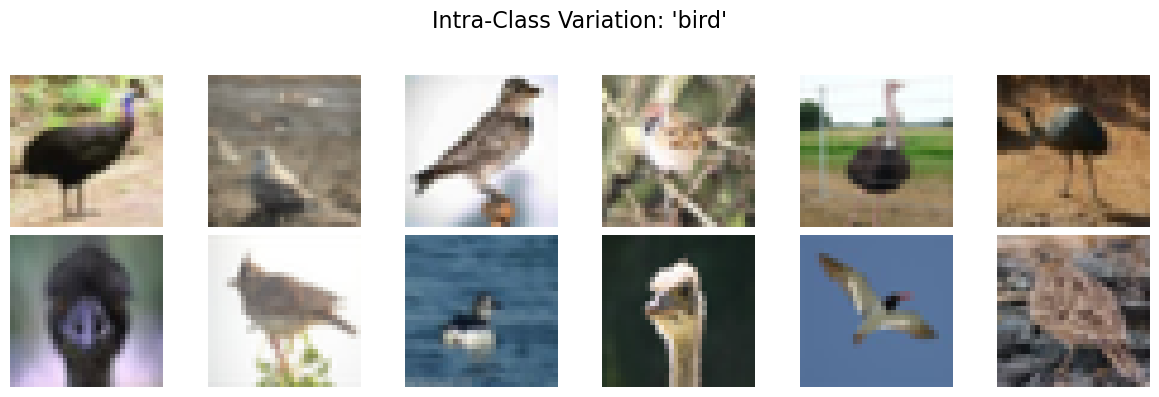

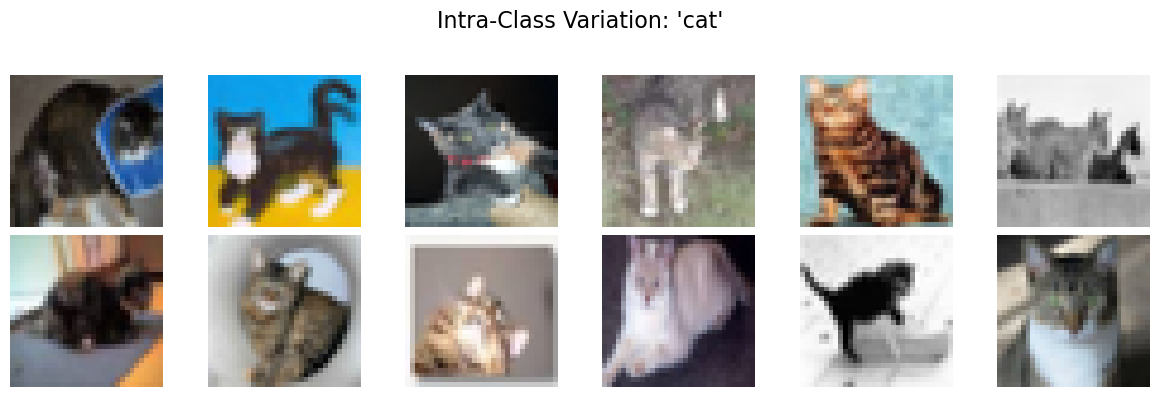

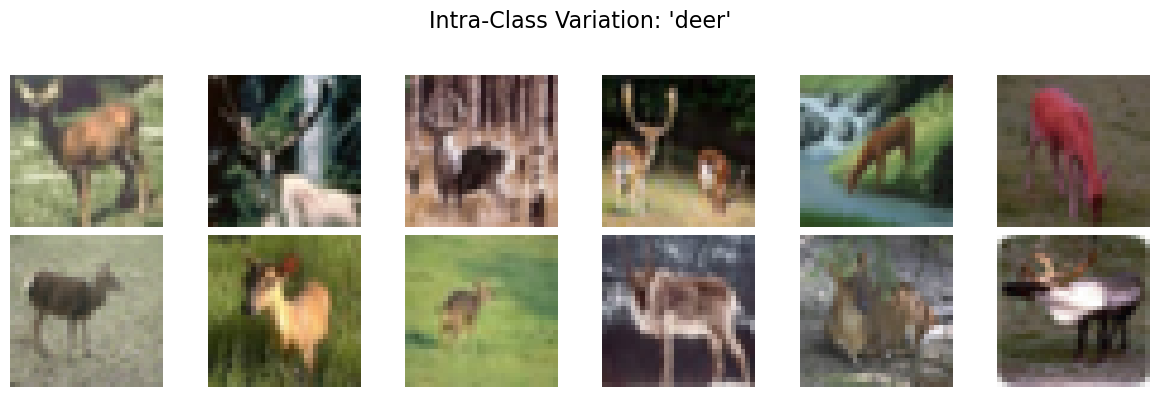

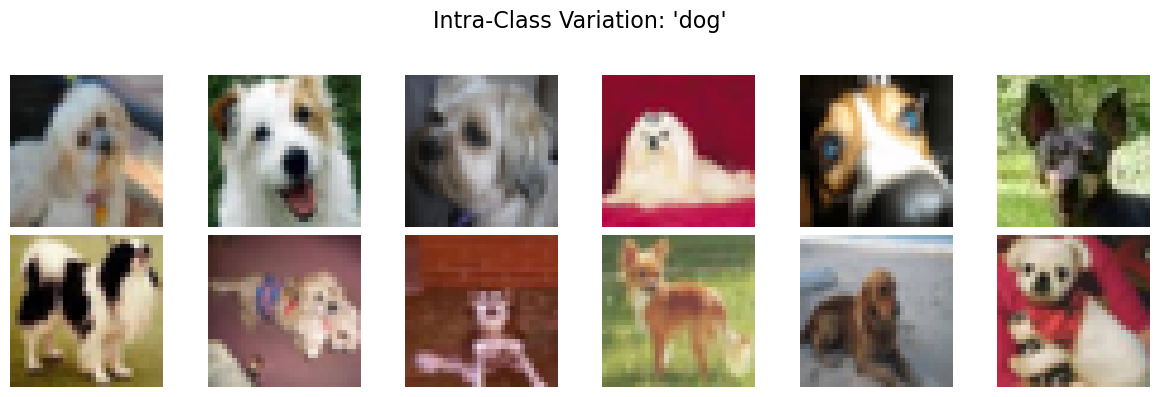

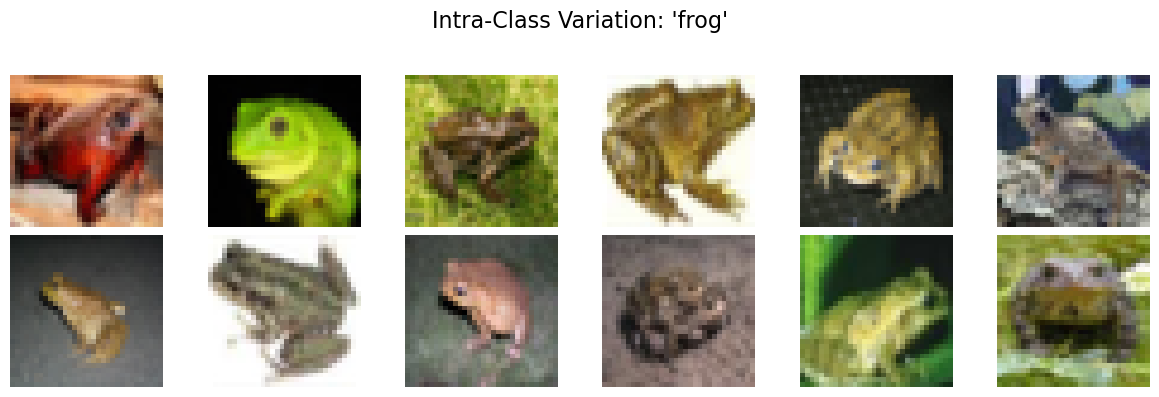

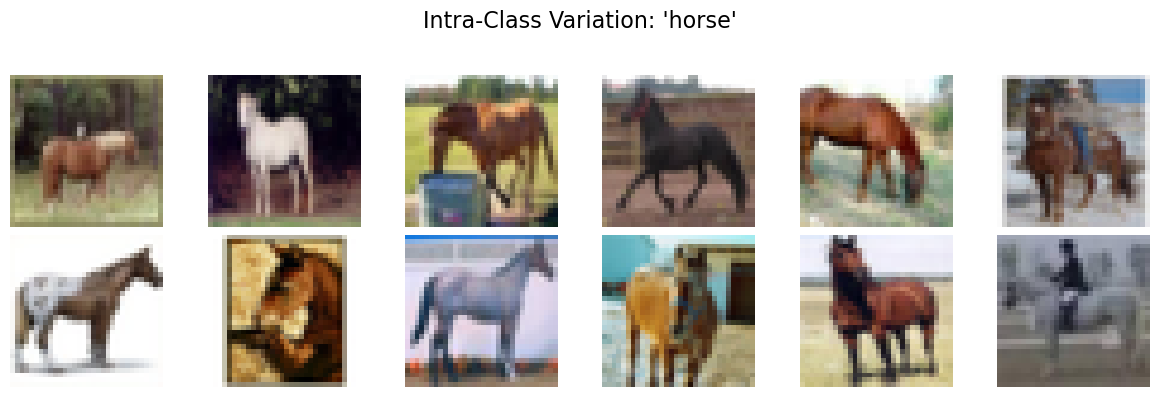

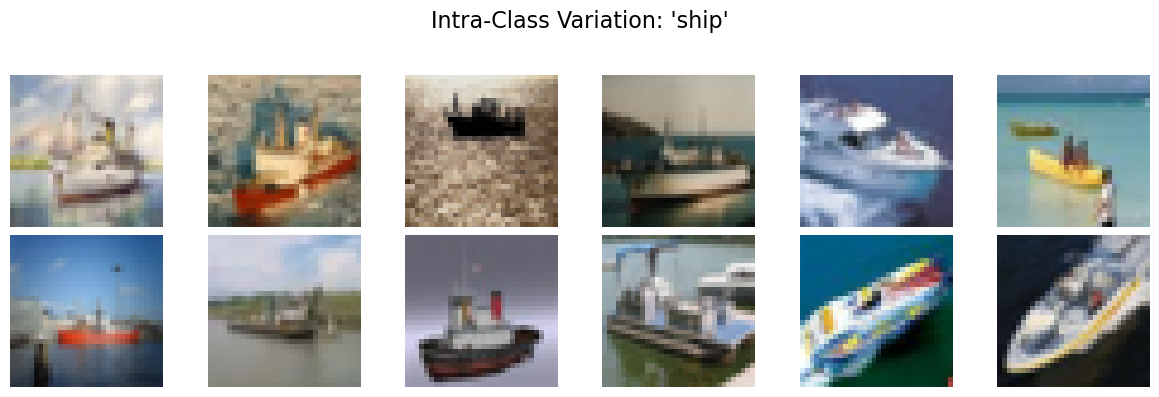

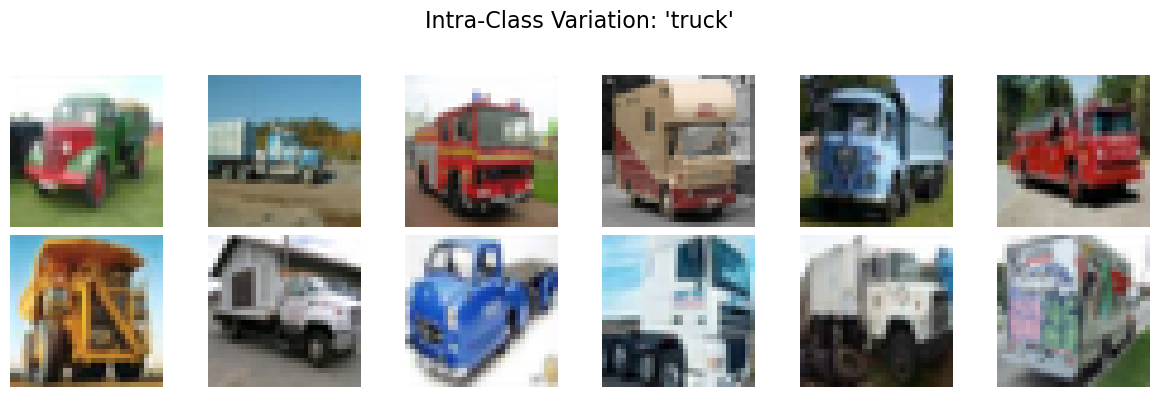

In [6]:
def plot_intra_class_variation(dataset, class_name, samples=12, cols=6):
    class_idx = dataset.class_to_idx[class_name]
    
    # Filter images for the given class
    class_images = [img for img, label in dataset if label == class_idx]
    selected_images = random.sample(class_images, min(samples, len(class_images)))

    # Plot
    rows = (samples + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    fig.suptitle(f"Intra-Class Variation: '{class_name}'", fontsize=16)

    for i in range(rows * cols):
        ax = axs[i // cols, i % cols] if rows > 1 else axs[i % cols]
        if i < len(selected_images):
            ax.imshow(selected_images[i])
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Show class variations

no_of_samples = 12

for class_name in cifar10_train.classes:
    plot_intra_class_variation(cifar10_train, class_name=class_name, samples=no_of_samples)

### Intra-Class Variation

The CIFAR-10 dataset exhibits a wide range of intra-class variation across different categories. This variation primarily stems from differences in pose, background, lighting conditions, color, and scale.

Observations based on the above samples:

- **Bird**: Appears in vastly different poses (flying, perching), backgrounds (sky, trees), lighting (backlit, sunny), and colors (bright yellows to deep browns). Species-level diversity also contributes to visual inconsistency.
- **Dog**: Includes many breeds of different sizes, fur textures, and colors. Images vary in pose and context (indoor vs. outdoor), adding further diversity.
- **Automobile**: Contains a wide array of vehicle types (sedans, vans, sports cars), angles (side, front, rear), and environments (city, showroom, parking lot), making generalization harder.

Other classes (e.g., ship, truck, horse) also vary but tend to retain more consistent structure or visual cues that help in recognition.

#### Implications

- **Model Complexity**: Greater variation demands more robust models capable of learning rich, hierarchical features.
- **Preprocessing**: Augmentation strategies such as flipping, cropping, and jittering are important to help the model generalize. Although bird, dog and automobile greated intra-class variation here, it is likely the samples not featured here in other classes exhibit similar variation.
- **Transfer Learning**: Leveraging pretrained models (e.g., on ImageNet) helps mitigate the impact of limited class uniformity.


## Recommended Data Augmentations

| Augmentation              | Reason                                                           |
|---------------------------|---------------------------------------------------------------------------|
| `RandomCrop` + padding    | Simulates translation, helps with localization variance                   |
| `RandomHorizontalFlip`    | Handles pose direction (e.g., mirrored animals/vehicles)                  |
| `ColorJitter`             | Adjusts brightness, contrast, saturation — useful for lighting variation |
| `RandomRotation`          | Helps when object orientation varies slightly (especially animals)        |
| `RandomAffine`            | Introduces translation/scale to handle minor geometric shifts             |
| `Cutout` or `RandomErasing` | Helps models become robust to occlusions or missing parts               |

